In [29]:
%%html
<style>
    @import url('https://fonts.googleapis.com/css2?family=Open+Sans:wght@100..900&display=swap');
    @page {
        size: A3 landscape;
        margin: 0;
    }
    .jp-Cell:first-child {
        display: none;
    }
    .jp-RenderedMermaid {
        justify-content: center;
    }
    body, div#notebook, .jp-RenderedHTMLCommon {
        font-family: "Open Sans", sans-serif !important;
        font-size: 30px !important;
        font-weight: 500;
        line-height: 1.4 !important;
    }
    body, p {
        margin: 0;
    }
    blockquote {
        border: none;
        text-align: center;
        opacity: 0.5;
    }
    blockquote p {
        text-align: inherit !important;
    }
    h1 {
        margin-top: 30% !important;
        text-align: center;
    }
    h2 {
        page-break-before: always;
    }
    h1, h2, h3, h4, h5, h6, strong {
        font-weight: 800;
    }
    h1 { 
        font-size: 225% !important;
    }
    h2 {
        font-size: 180% !important;
    }
    h3 {
        font-size: 150% !important;
    }
    h4 {
        font-size: 120% !important;
    }
    h5 {
        font-size: 110% !important;
    }
    h6 {
        font-size: 100% !important;
    }
    hr {
        page-break-after: always;
        visibility: hidden;
    }
    pre {
        white-space: pre-wrap;
    }
    table, td, th, tr, tbody, thead, tfoot {
        font-size: 92% !important;
        page-break-inside: avoid !important;
    }
    .anchor-link {
        display: none;
    }
    .MJXc-display {
        display: inline !important;
    }
    :root {
        --jp-content-link-color: dodgerblue;
    }
    a code {
        color: var(--jp-content-link-color) !important;
    }
    code, pre {
        font-family: Menlo, monospace !important;
    }
    h1, h2, h3, h4, h5, h6, strong {
        font-weight: 800 !important;
    }
    .jp-RenderedHTMLCommon td,
    .jp-RenderedHTMLCommon th,
    .jp-RenderedHTMLCommon tr {
        border: 1px solid var(--md-grey-500);
    }
    .jp-RenderedHTMLCommon table {
        margin-left: 2em;
    }
    .jp-CodeCell {
        margin-bottom: 1.5em;
    }
</style>

# View Synthesis

> Implementing NeRF in PyTorch

## Task Description

"View synthesis" is a task which
generating images of a 3D scene from a specific point of view.

## Solution Description

"NeRF" (Neural Radiance Field) solved "View synthesis"
by representing 3D scene using a neural network.

## Pipeline Description

Many modules compose the pipeline of NeRF:
1. Preprocessing
2. Inference
3. Rendering
4. Training

## Pipeline Description - Preprocessing

{{ True image }} → {{ Position, Direction, True color }}

## Pipeline Description - Inference

{{ Position, Direction }} → {{ Volumetric sampling }} → {{ Positional encoding }} → {{ Network }} → {{ Color, Density }}

## Pipeline Description - Rendering

{{ Color, Density }} → {{ Alpha blending }} → {{ Rendered color }}

## Pipeline Description - Training

{{ True color, Rendered color, Network }} → {{ Network }}

```mermaid
graph TD
    subgraph Preprocessing
        ti[True Image]
        cp[Camera Posture]
        tc[True Color]
    end

    subgraph Inference
        vs[Volume Sampling]
        B --> C[Ray Generation]
        C --> D[Ray Batching]
        D --> E[Volume Sampling]
        E --> F[Positional Encoding]
        F --> G[Network]
        G --> H[Color, Density]
    end

    subgraph Rendering
        H --> I[Alpha Blending]
        I --> J[Rendered Color]
    end

    subgraph Training
        B -.-> L[Loss Calculation]
        J -.-> L
        G -.-> L
        L --> G
    end
```

## Optimization Description

1. Positional Encoding of input coordinates
    - For learning high-frequency features
    - Using Fourier features
2. Stochastic Gradient Descent
    - For minimizing the error between the true and rendered images
    - Choosing a random image from the dataset each iteration
<!-- 3. Hierarchical Sampling
    - For high-frequency representions
    - Using two networks with different sample size -->

## Inference Details

### Positional Encoding

The raw and encoded coordinate values will be concatenated to form the network input.

Each coordinate value in `Position` and `Direction` is encoded as follows:

$$
Encode_{N}(p) \\

= \{\sin (2^0 \pi p), \cos (2^0 \pi p), \ldots, \sin (2^{N-1} \pi p), \cos (2^{N-1} \pi p)\} \\

= \{\sin (2^0 \pi p), \sin (\frac{\pi}{2} + 2^0 \pi p), \ldots, \sin (2^{N-1} \pi p), \sin (\frac{\pi}{2} + 2^{N-1} \pi p)\} \\

\text{where } p \in \mathbb{R}, \ N \in \mathbb{N}, \ Encode_{N}(p) \in \mathbb{R}^{2N}
$$

## Inference Details (Cont.)

### Positional Encoding (Cont.)

The encoded dimensions are calculated as follows:

| Input     | Dimension | N   | Encoded Dimension |
| --------- | --------- | --- | ----------------- |
| Position  | 3         | 10  | $3 (1 + 2N) = 63$ |
| Direction | 3         | 4   | $3 (1 + 2N) = 27$ |

## Inference Details (Cont.)

### Neural Prediction

The neural network is a multi-layer perceptron (MLP) with the following structure:
- The density is not dependent on the direction
- The fifth hidden layer concatenates the input as a skip connection

----

```mermaid
%%{init: {
    "theme": "neutral",
    "themeVariables": {
        "fontFamily": "Menlo, monospace",
        "fontSize": "8px"
    }
}}%%
flowchart TD
    ip1([Input Position 3])
    ep1([Encoded Position 63])
    h1([Hidden Layer 256])
    h2([Hidden Layer 256])
    h3([Hidden Layer 256])
    h4([Hidden Layer 256])
    h5([Hidden Layer 256])
    ip2([Input Position 3])
    ep2([Encoded Position 63])
    h6([Hidden Layer 256])
    h7([Hidden Layer 256])
    h8([Hidden Layer 256])
    od([Output Density 1])
    iof([Input/Output Feature 256])
    id([Input Direction 3])
    ed([Encoded Direction 27])
    ha([Additional Hidden Layer 128])
    oc([Output Color 3])

    ip1 -->|Encode| ep1
    ep1 -->|ReLU| h1
    h1 -->|ReLU| h2
    h2 -->|ReLU| h3
    h3 -->|ReLU| h4
    h4 -->|ReLU| h5
    ip2 -->|Encode| ep2
    ep2 ---|Concatenate| h5
    h5 -->|ReLU| h6
    h6 -->|ReLU| h7
    h7 -->|ReLU| h8
    h8 -->|ReLU| od
    h8 --> iof
    id -->|Encode| ed
    ed ---|Concatenate| iof
    iof -->|ReLU| ha
    ha -->|Sigmoid| oc

    style ip1 fill:palegreen
    style ip2 fill:palegreen
    style id fill:palegreen
    style ep2 fill:mediumaquamarine
    style ep1 fill:mediumaquamarine
    style ed fill:mediumaquamarine
    style h1 fill:deepskyblue
    style h2 fill:deepskyblue
    style h3 fill:deepskyblue
    style h4 fill:deepskyblue
    style h5 fill:deepskyblue
    style h6 fill:deepskyblue
    style h7 fill:deepskyblue
    style h8 fill:deepskyblue
    style ha fill:deepskyblue
    style iof fill:tan
    style od fill:salmon
    style oc fill:salmon
```

## Inference Details (Cont.)

### Stratified Point Sampling

To represent a continuous scene, we can sample points along the rays, which can be written as $r(t_{i}) = o + d t_{i}$ where:
- $o$ is the origin point
- $d$ is the direction vector
- $t_{i} \sim U[\frac{i - 1}{N}, \frac{i}{N}]$ is the distance along the ray (Stratified sampling)
- $N$ is the number of samples per ray

## Rendering Details (Cont.)

### Volume Rendering

$$
\hat{C} = \sum_{i=1}^{N} T_{i} \alpha_{i} c_{i} \\
$$

## Training Details

| Module Name                       | Details                                            |
| --------------------------------- | -------------------------------------------------- |
| Weight updater - Adam             | Learning rate is $5 \times 10^{-4}$                |
| Loss function - Mean Square Error | Error between the true and rendered image (colors) |
| Data loader                       | Batchify sample points to reduce memory cost       |


## References

1. View synthesis. (n.d.). In Wikipedia. Retrieved from https://en.wikipedia.org/wiki/View_synthesis
2. Neural radiance field. (n.d.). In Wikipedia. Retrieved from https://en.wikipedia.org/wiki/Neural_radiance_field
3. Mildenhall, B., Srinivasan, P. P., Tancik, M., Barron, J. T., Ramamoorthi, R., & Ng, R. (2020). NeRF: Neural radiance fields for image synthesis. arXiv preprint arXiv:2003.08934. Retrieved from https://arxiv.org/pdf/2003.08934
4. Tancik, M., Srinivasan, P. P., Mildenhall, B., Fridovich-Keil, S., Raghavan, N., Singhal, U., Ramamoorthi, R., Barron, J. T., & Ng, R. (2020). Fourier features let networks learn high frequency functions in low dimensional domains. NeurIPS. Retrieved from https://arxiv.org/pdf/2006.10739

## Implementation

----
#### Positional Encoding

In [30]:
from torch import Tensor
from torch.nn import Module
from torch.types import Device


class PositionalEncoder(Module):
    """
    ## Arguments
    - `encoding_factor`: `int`

    ## Inputs
    1. `Vectors`: `[..., dim]`

    ## Outputs
    1. `Features`: `[..., dim * (2 * encoding_factor + 1)]`
    """

    def __init__(self, encoding_factor: int, device: Device | None = None):
        import torch

        super(PositionalEncoder, self).__init__()

        encoding_factor = max(int(encoding_factor), 0)

        freq_lvls = torch.arange(encoding_factor, device=device)
        self.freq = ((2**freq_lvls) * torch.pi).repeat_interleave(2).unsqueeze_(-1)
        sine_offsets = torch.tensor([0.0, torch.pi / 2], device=device)
        self.offsets = sine_offsets.repeat(encoding_factor).unsqueeze_(-1)

    def forward(self, inputs: Tensor) -> Tensor:
        import torch

        inputs = torch.as_tensor(inputs).unsqueeze(-2)

        features = (self.freq * inputs + self.offsets).sin()
        features = torch.concat([inputs, features], dim=-2)
        features = features.reshape(*inputs.shape[:-2], -1)
        return features

    def get_last_dim(self, input_dim: int) -> int:
        return int(input_dim) * (self.freq.shape[0] + 1)

----
#### Neural Prediction

In [31]:
from torch import Tensor
from torch.nn import Module
from torch.types import Device


class MLP(Module):
    """
    ## Inputs
    1. `positions` + `directions`: `[..., 3 + 3]`

    ## Outputs
    1. `colors` + `densities`: `[..., 3 + 1]`
    """

    def __init__(
        self,
        layer_count: int | None = None,
        hidden_dim: int | None = None,
        additional_hidden_dim: int | None = None,
        position_encoder: PositionalEncoder | None = None,
        direction_encoder: PositionalEncoder | None = None,
        device: Device | None = None,
    ):
        from torch import nn

        super(MLP, self).__init__()

        layer_count = int(layer_count or 8)
        hidden_dim = int(hidden_dim or 256)
        additional_hidden_dim = int(additional_hidden_dim or hidden_dim // 2)
        if position_encoder is None:
            position_encoder = PositionalEncoder(10, device=device)
        if direction_encoder is None:
            direction_encoder = PositionalEncoder(4, device=device)

        COLOR_DIM = 3
        DENSITY_DIM = 1
        POSITION_DIM = 3
        DIRECTION_DIM = 3
        encoded_position_dim = position_encoder.get_last_dim(POSITION_DIM)
        encoded_direction_dim = direction_encoder.get_last_dim(DIRECTION_DIM)

        self.position_hidden_layer_skip_indexs = set(
            [i for i in range(1, layer_count - 1) if i % 4 == 0]
        )
        self.position_input_layer = nn.Linear(
            encoded_position_dim,
            hidden_dim,
            device=device,
        )
        self.position_hidden_layers = nn.ModuleList(
            [
                (
                    nn.Linear(
                        hidden_dim + encoded_position_dim,
                        hidden_dim,
                        device=device,
                    )
                    if i in self.position_hidden_layer_skip_indexs
                    else nn.Linear(
                        hidden_dim,
                        hidden_dim,
                        device=device,
                    )
                )
                for i in range(layer_count)
            ]
        )
        self.density_output_layer = nn.Linear(
            hidden_dim,
            DENSITY_DIM,
            device=device,
        )
        self.direction_input_layer = nn.Linear(
            hidden_dim + encoded_direction_dim,
            additional_hidden_dim,
            device=device,
        )
        self.color_output_layer = nn.Linear(
            additional_hidden_dim, COLOR_DIM, device=device
        )

        self.position_input_encoder = position_encoder
        self.direction_input_encoder = direction_encoder

    def forward(self, inputs: Tensor) -> tuple[Tensor, Tensor]:
        import torch

        inputs = torch.as_tensor(inputs)

        positions = inputs[..., 0:3]
        directions = inputs[..., 3:6]
        encoded_positions: Tensor = self.position_input_encoder(positions)
        encoded_directions: Tensor = self.direction_input_encoder(directions)

        hidden_positions: Tensor = self.position_input_layer(encoded_positions).relu()
        for index, layer in enumerate(self.position_hidden_layers):
            hidden_positions = layer(
                torch.concat([hidden_positions, encoded_positions], dim=-1)
                if index in self.position_hidden_layer_skip_indexs
                else hidden_positions
            )
            hidden_positions = hidden_positions.relu()

        density: Tensor = self.density_output_layer(hidden_positions).relu()
        hidden_directions: Tensor = self.direction_input_layer(
            torch.concat([hidden_positions, encoded_directions], dim=-1)
        ).relu()
        color: Tensor = self.color_output_layer(hidden_directions).sigmoid()

        return torch.concat([color, density], dim=-1)

----
#### Weight Update

In [32]:
from torch.optim import Adam
from torch.optim.optimizer import ParamsT


class AdamWeightUpdater(Adam):
    def __init__(self, parameters: ParamsT, learning_rate: float | None = None):
        learning_rate = float(learning_rate or 5e-4)

        super(AdamWeightUpdater, self).__init__(parameters, lr=learning_rate)

    def __call__(self, loss: Tensor) -> None:
        self.zero_grad()
        loss.backward()
        self.step()

----
#### Ray Generation

In [33]:
from torch import Tensor
from torch.nn import Module
from torch.types import Device


class RayGenerator(Module):
    """
    ## Arguments
    - `height`: `int`
    - `width`: `int`
    - `focal`: `float`

    ## Inputs
    1. `posture`: `[4, 4]`

    ## Outputs
    1. `origins`: `[height, width, 3]`
    2. `directions`: `[height, width, 3]`
    """

    def __init__(
        self,
        height: int,
        width: int,
        focal: float,
        device: Device | None = None,
    ):
        super(RayGenerator, self).__init__()

        import torch

        focal = float(focal)
        height = float(height)
        width = float(width)

        self.directions = torch.stack(
            torch.meshgrid(
                (torch.arange(width, device=device) - width / 2) / focal,
                -(torch.arange(height, device=device) - height / 2) / focal,
                torch.tensor(-1.0, device=device),
                indexing="xy",
            ),
            dim=-1,
        ).unsqueeze_(-2)

    def forward(self, posture: Tensor) -> Tensor:
        import torch

        posture = torch.as_tensor(posture)[:3]

        directions = (self.directions * posture[:, :3]).sum(dim=-1)
        origins = posture[:, 3].broadcast_to(directions.shape)
        return origins, directions

----
#### Stratified Point Sampling

In [34]:
from torch import Tensor
from torch.nn import Module


class StratifiedPointSampler(Module):
    """
    ## Arguments
    - `points_per_ray`: `int`

    ## Inputs
    1. `origins`: `[..., 1, 3]`
    2. `directions`: `[..., 1, 3]`

    ## Outputs
    1. `points`: `[..., points_per_ray, 3]`
    2. `intervals`: `[..., points_per_ray]` (Ended with `1e9`)
    """

    def __init__(self, points_per_ray: int | None = None, seed: int | None = None):
        super(StratifiedPointSampler, self).__init__()

        from torch import Generator

        points_per_ray = int(points_per_ray or 32)
        if seed is not None:
            seed = int(seed)

        self.generator: Generator = seed
        self.points_per_ray = points_per_ray

    def forward(self, origins: Tensor, directions: Tensor) -> Tensor:
        import torch

        origins = torch.as_tensor(origins)
        directions = torch.as_tensor(directions)

        device = origins.device
        if type(self.generator) is int:
            self.generator = torch.Generator(device).manual_seed(self.generator)

        distances = (
            torch.linspace(2.0, 6.0, self.points_per_ray, device=device)
            .repeat(*origins.shape[:-2], 1)
            .add_(
                torch.rand(
                    *origins.shape[:-2],
                    self.points_per_ray,
                    device=device,
                    generator=self.generator,
                ).mul_(4.0 / self.points_per_ray)
            )
        )
        intervals = torch.concat(
            [
                distances[..., 1:] - distances[..., :-1],
                torch.tensor(1e9, device=device).repeat(
                    (*origins.shape[:-2], 1),
                ),
            ],
            dim=-1,
        )
        points = origins + directions * distances.unsqueeze_(-1)
        return points, intervals

----
#### Volume Rendering

In [35]:
from torch import Tensor
from torch.nn import Module


class VolumeRenderer(Module):
    """
    ## Inputs
    1. `colors` + `densities`: `[..., points_per_ray, 3 + 1]`
    2. `intervals`: `[..., points_per_ray]`

    ## Outputs
    1. `rendered_colors`: `[..., 3]`
    """

    def forward(self, inputs: Tensor, intervals: Tensor) -> Tensor:
        import torch

        inputs = torch.as_tensor(inputs)

        colors = inputs[..., :3]
        densities = inputs[..., 3]
        translucency = (-densities * intervals).exp()
        transmittance = (1.0 - translucency) * torch.cumprod(translucency, dim=-1)
        rendered_colors = (transmittance.unsqueeze(-1) * colors).sum(dim=-2)
        return rendered_colors

----
#### Loss Function

In [36]:
from torch import Tensor


class MSELossFunction:
    def __call__(
        self,
        rendered_color: Tensor,
        target_color: Tensor,
    ) -> Tensor:
        from torch import as_tensor

        rendered_color = as_tensor(rendered_color)
        target_color = as_tensor(target_color)

        loss = (rendered_color - target_color).square().mean()
        return loss

----
#### Data Loader

In [37]:
from torch import Tensor
from torch.nn import Module
from typing import Iterator


class DataLoader(Module):
    def __init__(self, batch_size: int | None = None):
        super(DataLoader, self).__init__()

        batch_size = int(batch_size or 1)

        self.batch_size = batch_size

    def forward(self, inputs: Tensor) -> Iterator[Tensor]:
        from torch.utils.data import DataLoader as _DataLoader

        return iter(_DataLoader(inputs, batch_size=self.batch_size))

----
#### Dataset

In [38]:
from dataclasses import dataclass
from torch import Tensor
from torch.types import Device


@dataclass
class ViewSynthesisDataset:
    count: int
    focal: float
    height: int
    images: Tensor
    postures: Tensor
    width: int

    def __post_init__(self) -> None:
        if self.images.shape[0] != self.postures.shape[0]:
            raise ValueError("The number of images and postures must be the same")

    @staticmethod
    def from_numpy(url: str) -> "ViewSynthesisDataset":
        from httpx import get
        from io import BytesIO
        from numpy import load

        import torch

        try:
            file = BytesIO(
                get(url, follow_redirects=True, timeout=60).raise_for_status().content
            )
        except:
            file = open(url, "rb")

        with file as file_entered:
            arrays = load(file_entered)
            focal = float(arrays["focal"])
            images = torch.as_tensor(arrays["images"])
            postures = torch.as_tensor(arrays["poses"])

        return ViewSynthesisDataset(
            count=images.shape[0],
            focal=focal,
            height=images.shape[1],
            images=images,
            postures=postures,
            width=images.shape[2],
        )

    def get_image_and_posture(self, index: int | None = None) -> tuple[Tensor, Tensor]:
        from random import randint

        if index is not None:
            index = int(index)
        else:
            index = randint(0, self.count - 1)

        return self.images[index], self.postures[index]

    def set_device(self, device: Device) -> "ViewSynthesisDataset":
        self.images = self.images.to(device)
        self.postures = self.postures.to(device)
        return self

    def __repr__(self) -> str:
        repr = f"{self.__class__.__name__}("
        for name, value in self.__dict__.items():
            if isinstance(value, Tensor):
                value = f"Tensor(shape={tuple(value.shape)}, dtype={value.dtype})"
            elif type(value) is float:
                value = f"{value:.7f}"
            repr += f"\n  {name}={value},"
        repr += "\n)"
        return repr

----
#### NeRF Model

In [39]:
from torch import Tensor
from torch.nn import Module
from torch.types import Device


def display_image(image: Tensor):
    from IPython.display import display
    from PIL import Image
    from torch import uint8

    return display(Image.fromarray((image * 255).round().type(uint8).numpy()))


class NeRF(Module):
    """
    ## Arguments
    - `focal`: `float`
    - `height`: `int`
    - `width`: `int`

    ## Inputs
    1. `posture`: `[4, 4]`

    ## Outputs
    1. `rendered_image`: `[height, width, 3]`
    """

    def __init__(
        self,
        focal: float,
        height: int,
        width: int,
        points_per_ray: int | None = None,
        rays_per_batch: int | None = None,
        device: Device | None = None,
        seed: int | None = None,
    ):
        from random import seed as set_seed

        super(NeRF, self).__init__()

        points_per_ray = int(points_per_ray or 32)
        rays_per_batch = int(rays_per_batch or 1024)
        if seed is not None:
            seed = int(seed)
            set_seed(seed)

        points_per_batch = points_per_ray * rays_per_batch

        self.generate_rays = RayGenerator(
            focal=focal,
            height=height,
            width=width,
            device=device,
        )
        self.sample = StratifiedPointSampler(
            points_per_ray=points_per_ray,
            seed=seed,
        )
        self.load_batches = DataLoader(
            batch_size=points_per_batch,
        )
        self.predict = MLP(
            layer_count=12,
            hidden_dim=256,
            additional_hidden_dim=128,
            position_encoder=PositionalEncoder(10, device=device),
            direction_encoder=PositionalEncoder(4, device=device),
            device=device,
        )
        self.render = VolumeRenderer()

    def forward(self, posture: Tensor) -> Tensor:
        import torch

        origins: Tensor
        directions: Tensor
        positions: Tensor
        intervals: Tensor

        origins, directions = self.generate_rays(posture)
        positions, intervals = self.sample(origins, directions)
        positions_and_directions = torch.concat(
            [
                positions,
                directions.broadcast_to(positions.shape),
            ],
            dim=-1,
        ).reshape(
            (-1, 6),
        )
        colors_and_densities = torch.concat(
            [
                self.predict(batch)
                for batch in self.load_batches(positions_and_directions)
            ],
            dim=0,
        ).reshape(
            (*positions.shape[:-1], 4),
        )
        rendered_image = self.render(colors_and_densities, intervals)
        # display(
        #     dict(
        #         origins=origins[0, 0],
        #         directions=directions[0, 0],
        #         positions=positions[0, 0, 0],
        #         intervals=intervals[0, 0],
        #         colors_densities=colors_and_densities[0, 0],
        #         rendered_image=rendered_image[0, 0],
        #     )
        # )

        return rendered_image

    @staticmethod
    def fit(
        dataset: ViewSynthesisDataset,
        epochs: int | None = None,
        learning_rate: float | None = None,
        show_progress: bool | None = None,
        *,
        points_per_ray: int | None = None,
        rays_per_batch: int | None = None,
        device: Device | None = None,
        seed: int | None = None,
    ) -> "NeRF":
        import torch
        from tqdm import tqdm

        EPOCHS_PER_DEMO = 50

        dataset.set_device(device)
        epochs = int(epochs or 1)
        if show_progress is None:
            show_progress = True

        if show_progress:
            display_image(dataset.get_image_and_posture(-1)[0])

        def weight_initialize(module: Module):
            if type(module) is torch.nn.Linear:
                with torch.no_grad():
                    module.weight.fill_(1e-7)
                    module.bias.zero_()

        model = NeRF(
            focal=dataset.focal,
            height=dataset.height,
            width=dataset.width,
            points_per_ray=points_per_ray,
            rays_per_batch=rays_per_batch,
            device=device,
            seed=seed,
        ).apply(
            weight_initialize,
        )
        calculate_loss = MSELossFunction()
        update_weight = AdamWeightUpdater(
            parameters=model.parameters(),
            learning_rate=learning_rate,
        )
        progress = tqdm(
            disable=not show_progress,
            desc=f"Fitting NeRF model to {dataset.count}x images and postures",
            ascii="         |",
            colour="blue",
            dynamic_ncols=True,
            total=epochs,
        )

        with progress:
            for epoch in range(epochs):
                image, posture = dataset.get_image_and_posture()
                rendered_image: Tensor = model(posture)
                loss = calculate_loss(rendered_image, image)
                update_weight(loss)

                if show_progress and epoch % EPOCHS_PER_DEMO == 0:
                    with torch.no_grad():
                        posture_demo = dataset.get_image_and_posture(-1)[1]
                        rendered_image_demo = model(posture_demo)
                        display_image(rendered_image_demo)
                        display(f"{rendered_image_demo.max().item():.4f}")

                progress.update()

        return model

----
#### Training

In [40]:
# original_dataset = ViewSynthesisDataset.from_numpy("http://cseweb.ucsd.edu/~viscomp/projects/LF/papers/ECCV20/nerf/tiny_nerf_data.npz")
original_dataset = ViewSynthesisDataset.from_numpy("https://raw.githubusercontent.com/AsherJingkongChen/nerf/main/tiny_nerf_data.npz")

In [41]:
test_data_count = original_dataset.count // 5
test_dataset = ViewSynthesisDataset(
    count=test_data_count,
    focal=original_dataset.focal,
    height=original_dataset.height,
    images=original_dataset.images[-test_data_count:],
    postures=original_dataset.postures[-test_data_count:],
    width=original_dataset.width,
)
train_dataset = ViewSynthesisDataset(
    count=original_dataset.count - test_data_count,
    focal=original_dataset.focal,
    height=original_dataset.height,
    images=original_dataset.images[:-test_data_count],
    postures=original_dataset.postures[:-test_data_count],
    width=original_dataset.width,
)
train_dataset, test_dataset

(ViewSynthesisDataset(
   count=85,
   focal=138.8888789,
   height=100,
   images=Tensor(shape=(85, 100, 100, 3), dtype=torch.float32),
   postures=Tensor(shape=(85, 4, 4), dtype=torch.float32),
   width=100,
 ),
 ViewSynthesisDataset(
   count=21,
   focal=138.8888789,
   height=100,
   images=Tensor(shape=(21, 100, 100, 3), dtype=torch.float32),
   postures=Tensor(shape=(21, 4, 4), dtype=torch.float32),
   width=100,
 ))

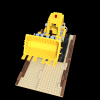

Fitting NeRF model to 85x images and postures:   0%|          | 0/1000 [00:00<?, ?it/s]

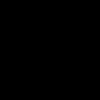

'0.0010'

Fitting NeRF model to 85x images and postures:   1%|          | 12/1000 [01:53<2:35:33,  9.45s/it]

In [42]:
model = NeRF.fit(
    dataset=train_dataset,
    device="cpu",
    epochs=1000,
    rays_per_batch=500,
    points_per_ray=60,
    seed=1,
)

----
#### Validation

(tensor([[-1.5836,  1.0135,  1.0806,  0.9657, -0.0426, -0.2506,  0.2597, -0.9991,
          -0.9681,  0.5015,  0.0850,  0.4852, -0.8652,  0.9964,  0.8744, -0.8677,
           0.1694,  0.8486,  0.4970,  0.9855,  0.5291, -0.8626,  0.3340,  0.8979,
          -0.5060,  0.9426, -0.4401,  0.8729,  0.6296, -0.7904, -0.4880,  0.7769,
          -0.6126, -0.8519,  0.9783,  0.9684, -0.5237,  0.2072, -0.2494,  0.8923,
           0.4053, -0.4831, -0.4514, -0.9142, -0.8756, -0.8056, -0.7411,  0.8460,
          -0.5925,  0.6714,  0.5332,  0.9546, -0.9951,  0.9022, -0.2979, -0.0985,
          -0.4313, -0.5688,  0.1960, -0.7783, -0.8225, -0.9806, -0.6279],
         [-1.0057,  1.1241,  1.1803,  0.0180, -0.3802, -0.5366, -0.9998, -0.9249,
          -0.8439, -0.0361,  0.7032,  0.9056,  0.9993,  0.7110,  0.4242, -0.0721,
           0.9999,  0.7683,  0.9974,  0.0109, -0.6401, -0.1438,  0.0219, -0.9836,
           0.9896, -0.9998, -0.1806, -0.2846, -0.0437,  0.3552,  0.9586,  0.9990,
          -0.9348, -0.54

(0, 16.147069931030273)

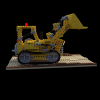

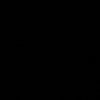

(tensor([[-0.2737, -0.7554,  2.2168, -0.7577, -0.6951,  0.6296,  0.6526, -0.7189,
           0.7770, -0.9890,  0.9994,  0.9783, -0.1482,  0.0337,  0.2073,  0.2931,
           0.0673,  0.4056, -0.9561, -0.9977, -0.9140, -0.5604, -0.1343, -0.7415,
           0.8282,  0.9909,  0.6710, -0.9283, -0.2661, -0.9950,  0.3719,  0.9639,
          -0.0996, -0.6905, -0.5131,  0.1982, -0.7233,  0.8583, -0.9802,  0.9989,
          -0.8808, -0.3886,  0.0464,  0.4735,  0.9214,  0.0927, -0.8341, -0.7161,
          -0.9957, -0.5516,  0.6980, -0.1846,  0.9202, -0.9997,  0.9828, -0.3915,
          -0.0256, -0.3629, -0.7204,  0.0511,  0.9318, -0.6935, -0.9987],
         [-0.7447, -0.5012,  1.7825, -0.7187, -1.0000, -0.6313, -0.6953, -0.0038,
           0.7755,  0.9995,  0.0077, -0.9792, -0.0331, -1.0000,  0.2029, -0.0662,
          -0.0153, -0.3973, -0.9978,  0.9999, -0.9177,  0.1321, -0.0307,  0.7292,
           0.9912,  0.9995,  0.6843,  0.2620, -0.0613,  0.9980,  0.9651,  0.9981,
          -0.0636,  0.50

(1, 8.403759956359863)

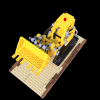

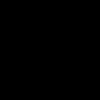

(tensor([[-9.3759e-01,  2.5879e-01,  2.2057e+00, -1.9482e-01,  7.2637e-01,
           6.0210e-01, -9.8084e-01,  6.8730e-01,  7.9842e-01,  3.8218e-01,
           9.9847e-01,  9.6146e-01,  9.2409e-01, -5.5230e-02,  2.7496e-01,
           7.0633e-01, -1.1029e-01,  5.2872e-01,  7.0788e-01, -9.9390e-01,
          -8.4880e-01,  1.0000e+00,  2.1924e-01, -8.9755e-01,  2.1986e-03,
           9.7567e-01,  4.4091e-01,  4.3985e-03,  4.2780e-01, -7.9148e-01,
          -9.9999e-01,  9.0387e-01, -6.1120e-01, -8.7968e-03,  7.7336e-01,
           9.6750e-01,  9.9996e-01,  6.3397e-01, -2.5288e-01, -1.7593e-02,
           9.8057e-01, -4.8931e-01,  9.9985e-01, -1.9617e-01, -8.7211e-01,
          -3.5180e-02, -3.8472e-01,  8.5346e-01,  9.9938e-01, -9.2303e-01,
           5.2115e-01, -7.0317e-02,  7.1023e-01,  8.8957e-01,  9.9752e-01,
           7.0397e-01, -4.5680e-01, -1.4029e-01,  9.9996e-01, -8.1270e-01,
           9.9011e-01, -8.8447e-03, -5.8267e-01],
         [-4.4770e-01,  8.2360e-01,  1.7083e+00, -

(2, 9.927273750305176)

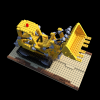

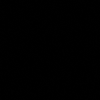

(tensor([[ 0.6879, -0.5671,  2.2381,  0.8307, -0.9779,  0.6801, -0.5567, -0.2093,
           0.7331, -0.9250,  0.4093,  0.9972, -0.3801, -0.9124,  0.0748,  0.7031,
          -0.7469,  0.1492, -0.7111,  0.6649, -0.9888, -0.9999, -0.9933, -0.2951,
           0.0112, -0.1158,  0.9555, -0.0225,  0.2300, -0.5639, -0.9997, -0.9732,
           0.8258,  0.0449, -0.4476, -0.9314,  0.9990,  0.8942,  0.3640,  0.0897,
          -0.8005, -0.6781,  0.9960,  0.5993, -0.7349,  0.1787, -0.9595,  0.9968,
           0.9839, -0.2817,  0.0803,  0.3517,  0.5406,  0.1601,  0.9361, -0.8413,
          -0.9871,  0.6584, -0.9096, -0.3161,  0.7527,  0.4155,  0.9487],
         [ 1.0384, -0.8893,  1.3310, -0.1203, -0.3409, -0.8623, -0.9927, -0.9401,
          -0.5064,  0.2389,  0.6410,  0.8733,  0.9710,  0.7676, -0.4871,  0.4640,
           0.9840, -0.8509,  0.8858,  0.1783, -0.5254,  0.8221,  0.3508,  0.8941,
           0.5694, -0.9364, -0.4480,  0.9362, -0.6571, -0.8010, -0.3516,  0.7538,
          -0.5987, -0.65

(3, 10.564596176147461)

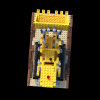

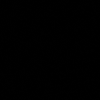

(tensor([[-8.3785e-01, -1.9570e+00,  1.0996e+00, -4.8765e-01,  1.3458e-01,
          -3.0790e-01, -8.7304e-01,  9.9090e-01, -9.5142e-01,  8.5148e-01,
           2.6671e-01,  5.8589e-01,  5.2439e-01,  9.6378e-01,  8.1039e-01,
           8.9301e-01,  5.1411e-01,  9.4960e-01, -4.5003e-01,  8.5773e-01,
           3.1348e-01, -8.0377e-01,  8.8193e-01,  5.9535e-01, -5.9494e-01,
           4.7139e-01, -8.0347e-01,  9.5639e-01,  8.3146e-01, -9.5669e-01,
          -2.9208e-01, -5.5558e-01,  2.9111e-01, -5.5869e-01, -9.2389e-01,
          -5.5701e-01, -8.2938e-01, -3.8264e-01, -8.3051e-01,  9.2673e-01,
           7.0705e-01,  9.2520e-01,  3.7572e-01, -7.0716e-01,  3.7948e-01,
           6.9640e-01, -1.0000e+00,  7.0219e-01, -7.1766e-01,  1.5314e-04,
          -7.1199e-01, -9.9955e-01, -2.9738e-04, -9.9990e-01,  3.0071e-02,
          -1.0000e+00,  1.3864e-02, -6.0107e-02,  5.9476e-04, -2.7717e-02,
          -9.9819e-01,  1.0000e+00, -9.9962e-01],
         [-1.0664e+00, -1.0156e+00,  1.2257e+00,  

(4, 10.914176940917969)

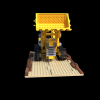

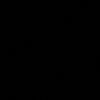

(tensor([[-1.4596,  0.5851,  1.6755,  0.9920,  0.9645, -0.8518, -0.1266, -0.2642,
           0.5239, -0.2512, -0.5096, -0.8925, -0.9679, -0.8604, -0.4510,  0.4863,
           0.8770,  0.8051,  0.8738,  0.4805, -0.5932,  0.8499,  0.8428, -0.9551,
           0.5270, -0.5382, -0.2963,  0.8957, -0.9072,  0.5660, -0.4446, -0.4207,
          -0.8244, -0.7965,  0.7633, -0.9333, -0.6047, -0.6461,  0.3592,  0.9632,
          -0.9863, -0.6704, -0.2687, -0.1652, -0.7420, -0.5176,  0.3259,  0.9949,
          -0.8556, -0.9454,  0.1010,  0.8857, -0.6162,  0.2010,  0.4642,  0.7876,
          -0.9796,  0.8223, -0.9706, -0.3938, -0.5691,  0.2406,  0.9192],
         [-0.7731,  0.8893,  1.5327, -0.6540,  0.3407, -0.9947, -0.7565, -0.9402,
           0.1026,  0.9895, -0.6406, -0.2041,  0.1447,  0.7678, -0.9790,  0.2863,
          -0.9838,  0.3996, -0.9581,  0.1792,  0.9167, -0.5486, -0.3526,  0.7326,
           0.8361, -0.9358,  0.6806, -0.9174,  0.6599,  0.9973,  0.3980,  0.7514,
          -0.0735, -0.73

(5, 12.060806274414062)

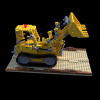

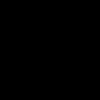

(tensor([[-0.6426, -0.1269,  2.3068, -0.9013, -0.3880,  0.8213, -0.4331,  0.9216,
           0.5704,  0.7808, -0.7153,  0.9370, -0.6248,  0.6988, -0.3492, -0.9757,
          -0.9997, -0.6544, -0.2192, -0.0233, -0.7561,  0.4277,  0.0465,  0.9897,
          -0.9039, -0.9989,  0.1434, -0.7732, -0.0929,  0.2839,  0.6341,  0.9957,
          -0.9589, -0.9807, -0.1850, -0.5444, -0.1957,  0.9827,  0.8389,  0.3839,
          -0.3636, -0.9133, -0.9234,  0.9316,  0.4074, -0.7089, -0.6774, -0.7441,
           0.7053,  0.7356, -0.6681, -1.0000, -0.9966,  0.9942, -0.0052,  0.0824,
          -0.1072,  0.0104, -0.1642, -0.2132, -0.9999, -0.9864, -0.9770],
         [-1.0069,  0.3053,  1.6428,  0.0216,  0.8187, -0.9010, -0.9998,  0.5742,
           0.4338, -0.0432,  0.9402, -0.7818,  0.9991, -0.3405, -0.6236, -0.0863,
          -0.6404,  0.9750,  0.9963, -0.7681, -0.2224, -0.1720,  0.9837, -0.4336,
           0.9851,  0.1798, -0.9011, -0.3388,  0.3538,  0.7814,  0.9408, -0.9353,
           0.6240, -0.63

(6, 9.438700675964355)

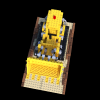

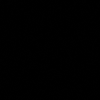

(tensor([[-1.0017, -0.1621,  1.9466,  0.0053, -0.4874, -0.1671, -1.0000,  0.8732,
           0.9859, -0.0106, -0.8512, -0.3296,  0.9999,  0.5249,  0.9441, -0.0213,
          -0.8935, -0.6223,  0.9998, -0.4490,  0.7828, -0.0426,  0.8024, -0.9742,
           0.9991, -0.5968,  0.2255, -0.0851, -0.9577, -0.4394,  0.9964, -0.2877,
          -0.8983, -0.1695,  0.5511,  0.7895,  0.9855, -0.8344,  0.6138, -0.3341,
          -0.9198,  0.9691,  0.9425,  0.3925, -0.2465, -0.6298, -0.7220, -0.4778,
           0.7767, -0.6919, -0.8785, -0.9784,  0.9991,  0.8394,  0.2066, -0.0426,
           0.5434, -0.4043, -0.0850,  0.9124, -0.9146, -0.9964, -0.4093],
         [-0.8668,  0.5458,  1.5670, -0.4064,  0.9897, -0.9779, -0.9137, -0.1433,
           0.2089,  0.7426, -0.2836, -0.4085,  0.6697, -0.9589, -0.9127,  0.9947,
           0.5440,  0.7458, -0.1029,  0.8391,  0.6662, -0.2047,  0.9129,  0.9937,
          -0.9788,  0.4082, -0.1123,  0.4008,  0.7453, -0.2232,  0.9162, -0.6668,
          -0.9748,  0.73

(7, 8.966991424560547)

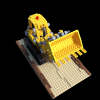

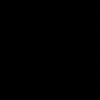

(tensor([[-0.5922,  0.6070,  1.9304, -0.9584,  0.9441, -0.2168, -0.2855, -0.3298,
           0.9762,  0.5473, -0.6226, -0.4234, -0.8370, -0.7825,  0.9060, -0.9161,
           0.9744, -0.7671,  0.4010,  0.2247,  0.6415, -0.7347,  0.4378, -0.9842,
          -0.6784, -0.8991, -0.1768,  0.9968, -0.7873,  0.3481, -0.0796,  0.6166,
          -0.9375, -0.1587, -0.9709, -0.6526, -0.9873, -0.2396,  0.7577,  0.3134,
           0.4653, -0.9890,  0.9496, -0.8852,  0.1481,  0.5953, -0.8237, -0.2929,
           0.8035,  0.5670, -0.9561,  0.9566, -0.9341,  0.5602,  0.2913, -0.3570,
           0.8284,  0.5574,  0.6670,  0.9281, -0.8303, -0.7451,  0.3724],
         [-0.4981,  0.7270,  1.8189, -1.0000,  0.7563, -0.5388,  0.0060, -0.6542,
           0.8424, -0.0121, -0.9896, -0.9079, -0.9999, -0.1441,  0.4193,  0.0241,
           0.2851, -0.7613,  0.9997, -0.9585, -0.6484,  0.0482, -0.5466,  0.9873,
           0.9988,  0.8374, -0.1592,  0.0963, -0.9155, -0.3143,  0.9954,  0.4024,
          -0.9493,  0.19

(8, 9.89918041229248)

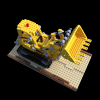

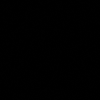

(tensor([[-6.8300e-01,  1.2349e+00,  1.6894e+00, -8.3924e-01, -6.7268e-01,
          -8.2822e-01, -5.4376e-01, -7.3993e-01,  5.6041e-01,  9.1269e-01,
           9.9548e-01, -9.2828e-01, -4.0866e-01,  9.5001e-02, -3.7189e-01,
          -7.4595e-01,  1.8914e-01,  6.9043e-01, -6.6600e-01, -9.8195e-01,
          -7.2340e-01,  9.9361e-01, -3.7146e-01, -9.9891e-01, -1.1289e-01,
           9.2845e-01,  4.6617e-02, -2.2434e-01, -6.8976e-01, -9.3131e-02,
          -9.7451e-01,  7.2404e-01, -9.9565e-01,  4.3724e-01, -9.9882e-01,
           1.8545e-01,  8.9935e-01,  4.8471e-02,  9.8265e-01,  7.8646e-01,
          -9.6835e-02,  3.6447e-01,  6.1764e-01, -9.9530e-01,  9.3121e-01,
           9.7150e-01,  1.9276e-01,  6.7880e-01, -2.3703e-01,  9.8125e-01,
           7.3432e-01, -4.6054e-01,  3.7829e-01,  9.9692e-01, -8.8764e-01,
           9.2569e-01,  7.8459e-02,  8.1759e-01,  7.0035e-01,  1.5644e-01,
           5.7580e-01,  7.1379e-01, -9.8769e-01],
         [-1.2770e-03,  1.1234e+00,  1.5329e+00, -

(9, 12.579294204711914)

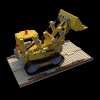

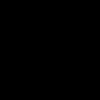

(tensor([[ 1.0935, -1.4736,  1.0335, -0.2896,  0.9966, -0.1050, -0.9571, -0.0829,
          -0.9945,  0.5544, -0.1652,  0.2088,  0.8322, -0.9863,  0.9779,  0.9228,
           0.3258,  0.4085,  0.3852,  0.9454,  0.9128,  0.7109,  0.6161,  0.7457,
          -0.7033,  0.7877,  0.6663, -0.9999,  0.9706,  0.9937, -0.0108,  0.2409,
          -0.1121,  0.0216,  0.4676, -0.2228, -0.9998, -0.8839, -0.9749, -0.0432,
          -0.8266,  0.4345,  0.9991,  0.5627,  0.9007, -0.0863, -0.9303,  0.7826,
           0.9963, -0.3667,  0.6225, -0.1719,  0.6823,  0.9743,  0.9851, -0.7311,
          -0.2251, -0.3386, -0.9976, -0.4386,  0.9409,  0.0689, -0.8987],
         [ 0.9592, -1.4551,  1.0620,  0.1278,  0.9901, -0.1935, -0.9918, -0.1405,
          -0.9811, -0.2536, -0.2783,  0.3796,  0.9673, -0.9605,  0.9252, -0.4906,
           0.5346,  0.7024,  0.8714,  0.8451,  0.7118, -0.8549,  0.9036,  0.9999,
           0.5187,  0.4284,  0.0133, -0.8869,  0.7742,  0.0267, -0.4619, -0.6329,
          -0.9996,  0.81

(10, 11.29494571685791)

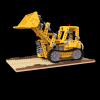

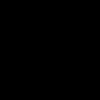

(tensor([[-0.8198,  1.3401,  1.6234, -0.5363, -0.8765, -0.9258, -0.8440, -0.4815,
           0.3781,  0.9053,  0.8440, -0.7001,  0.4248, -0.5364, -0.7141,  0.7691,
          -0.9054,  0.9998, -0.6391, -0.4246,  0.0198, -0.9831,  0.7688,  0.0395,
          -0.1830, -0.6394, -0.9992,  0.3598, -0.9833, -0.0790, -0.9330, -0.1822,
           0.9969, -0.6714,  0.3584, -0.1575,  0.7411, -0.9336,  0.9875, -0.9952,
          -0.6691, -0.3111,  0.0983,  0.7432,  0.9504, -0.1957, -0.9945, -0.5913,
          -0.9807,  0.1046,  0.8064,  0.3839, -0.2079, -0.9537,  0.9234, -0.9781,
           0.3006,  0.7089,  0.4068, -0.5734,  0.7053,  0.9135, -0.8193],
         [ 0.0124,  1.1631,  1.4858,  0.0389, -0.4901, -0.9990,  0.9992, -0.8716,
          -0.0446,  0.0777,  0.8544,  0.0890,  0.9970,  0.5195, -0.9960,  0.1549,
           0.8878, -0.1774,  0.9879, -0.4602,  0.9841,  0.3060, -0.8171, -0.3491,
           0.9520, -0.5765,  0.9371,  0.5827,  0.9421, -0.6543,  0.8127, -0.3353,
           0.7562,  0.94

(11, 12.97541618347168)

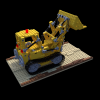

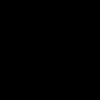

(tensor([[-1.5024,  0.7992,  1.6516,  1.0000,  0.5898, -0.8887,  0.0074, -0.8075,
           0.4586,  0.0149, -0.9526, -0.8150, -0.9999,  0.3042, -0.5794, -0.0298,
          -0.5796,  0.9445,  0.9996, -0.8149, -0.3286, -0.0595,  0.9446, -0.6207,
           0.9982,  0.3281, -0.7841, -0.1189,  0.6199,  0.9733,  0.9929, -0.7847,
           0.2296, -0.2360, -0.9729,  0.4468,  0.9717,  0.2314, -0.8946, -0.4588,
          -0.4502, -0.7995,  0.8886, -0.8929,  0.6007, -0.8153,  0.8040, -0.9605,
           0.5791,  0.5946, -0.2784, -0.9442,  0.9562,  0.5348, -0.3293, -0.2929,
          -0.8450,  0.6219, -0.5601, -0.9037, -0.7831, -0.8284,  0.4281],
         [-0.6290,  1.0181,  1.5066, -0.9190, -0.0569, -0.9998, -0.3942, -0.9984,
           0.0207,  0.7245,  0.1136, -0.0415, -0.6893,  0.9935, -0.9991, -0.9988,
           0.2257,  0.0829, -0.0498,  0.9742,  0.9966,  0.0995,  0.4398,  0.1652,
          -0.9950,  0.8981,  0.9863, -0.1981,  0.7900,  0.3259,  0.9802,  0.6131,
           0.9454, -0.38

(12, 12.640952110290527)

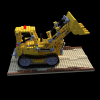

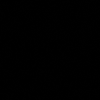

(tensor([[-0.8062, -1.7379,  1.4275, -0.5720,  0.7334, -0.9742, -0.8203,  0.6798,
          -0.2257,  0.9383,  0.9971,  0.4397,  0.3457, -0.0757, -0.8982,  0.6488,
          -0.1510, -0.7898, -0.7609, -0.9885,  0.6133, -0.9874,  0.2986, -0.9689,
           0.1581,  0.9544, -0.2476, -0.3122,  0.5699,  0.4798, -0.9500,  0.8217,
          -0.8774,  0.5931,  0.9366, -0.8419,  0.8051,  0.3504,  0.5396,  0.9551,
           0.6563, -0.9086,  0.2964, -0.7545, -0.4177,  0.5662, -0.9904,  0.7590,
          -0.8243,  0.1384, -0.6511, -0.9334, -0.2742, -0.9884,  0.3589, -0.9617,
          -0.1522, -0.6699,  0.5274,  0.3008, -0.7424,  0.8496, -0.9537],
         [-0.9597, -1.1206,  1.4070, -0.1262,  0.3697, -0.9576, -0.9920, -0.9291,
          -0.2880,  0.2504, -0.6871,  0.5516,  0.9682,  0.7266, -0.8341,  0.4848,
          -0.9984, -0.9202,  0.8746,  0.0558,  0.3914,  0.8480, -0.1115, -0.7203,
           0.5300, -0.9938, -0.6936,  0.8988,  0.2216,  0.9993, -0.4383,  0.9751,
          -0.0378, -0.78

(13, 9.803068161010742)

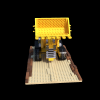

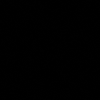

(tensor([[ 0.3800, -0.9191,  2.1762,  0.9298, -0.2516,  0.5256,  0.3681, -0.9678,
           0.8507,  0.6845,  0.4870,  0.8943, -0.7290,  0.8734,  0.4475, -0.9980,
           0.8506,  0.8004,  0.0628,  0.5257, -0.5995, -0.1253,  0.8944, -0.9596,
          -0.9921, -0.4472, -0.2813,  0.2487, -0.8000,  0.5399,  0.9686, -0.6001,
          -0.8417,  0.4818,  0.9600, -0.9089,  0.8763, -0.2799,  0.4170,  0.8444,
          -0.5374, -0.7580,  0.5357, -0.8434, -0.6522,  0.9047,  0.9064,  0.9888,
          -0.4260,  0.4225, -0.1492, -0.7708,  0.7659, -0.2951, -0.6370, -0.6430,
          -0.9555,  0.9821, -0.9849,  0.5638, -0.1883, -0.1731,  0.8259],
         [-0.5671, -0.8568,  1.5692, -0.9778, -0.4349, -0.9765, -0.2094, -0.9005,
           0.2156,  0.4094,  0.7832, -0.4210, -0.9123,  0.6218, -0.9071, -0.7471,
           0.9740,  0.7637,  0.6647, -0.2268,  0.6455, -0.9932, -0.4417,  0.9860,
          -0.1163, -0.8972, -0.1666,  0.2311,  0.7925, -0.3285, -0.9729,  0.6098,
          -0.9445, -0.44

(14, 8.542769432067871)

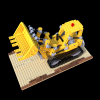

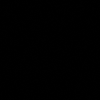

(tensor([[ 0.6073, -0.4934,  2.1397,  0.9437, -0.9998,  0.4248, -0.3307,  0.0208,
           0.9053, -0.6242, -0.0415,  0.7692, -0.7812, -0.9991,  0.6391,  0.9753,
           0.0829,  0.9831,  0.2207,  0.9966, -0.1832,  0.4305,  0.1653, -0.3602,
          -0.9026,  0.9862, -0.9329, -0.7771,  0.3260,  0.6721,  0.6294,  0.9454,
           0.7405, -0.9782,  0.6164,  0.9953, -0.2077,  0.7874,  0.0966,  0.4063,
           0.9707,  0.1922, -0.9137,  0.2401, -0.9813, -0.7425,  0.4662, -0.3773,
           0.6698, -0.8847,  0.9261, -0.9947, -0.8248, -0.6989, -0.1027,  0.5654,
           0.7153,  0.2043, -0.9327, -0.9997, -0.9789, -0.3606,  0.0232],
         [ 0.7802, -1.0239,  1.3590,  0.6368,  0.0752, -0.9034, -0.7710, -0.9972,
          -0.4287, -0.9820, -0.1499,  0.7746,  0.1889,  0.9887, -0.6324, -0.3710,
          -0.2964, -0.9798, -0.9286,  0.9551, -0.2001,  0.6890, -0.5662,  0.3921,
           0.7247,  0.8243, -0.9199,  0.9987, -0.9334, -0.7213,  0.0505,  0.3589,
           0.6926,  0.10

(15, 10.557012557983398)

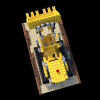

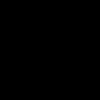

(tensor([[-1.1915, -0.2368,  2.0795,  0.5660, -0.6772,  0.2471, -0.8244,  0.7358,
           0.9690, -0.9332, -0.9966,  0.4788,  0.3593,  0.0828,  0.8779, -0.6706,
          -0.1650,  0.8407, -0.7418, -0.9863,  0.5415,  0.9949,  0.3255,  0.9105,
           0.1006,  0.9456, -0.4136,  0.2002,  0.6155, -0.7532, -0.9797,  0.7881,
          -0.6578, -0.3923,  0.9702,  0.9909,  0.9198,  0.2423, -0.1345, -0.7218,
           0.4702, -0.2665,  0.6921, -0.8826, -0.9638, -0.9991, -0.8300,  0.5138,
          -0.0419,  0.5578,  0.8579,  0.0837, -0.9259,  0.8816, -0.9965, -0.3777,
           0.4720, -0.1669,  0.6995,  0.8323,  0.9860, -0.7147, -0.5544],
         [-0.7914,  0.6022,  1.6245, -0.6094,  0.9489, -0.9245, -0.7929, -0.3157,
           0.3811,  0.9663, -0.5991, -0.7047,  0.2573, -0.8007, -0.7095,  0.4973,
           0.9594,  1.0000, -0.8676,  0.2821,  0.0068, -0.8629,  0.5413,  0.0137,
           0.5054, -0.8408, -0.9999, -0.8722, -0.9103, -0.0274, -0.4892,  0.4139,
           0.9996,  0.85

(16, 9.416409492492676)

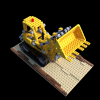

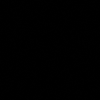

(tensor([[ 0.7529,  0.7645,  1.9352,  0.7007,  0.6743, -0.2020, -0.7135, -0.7385,
           0.9794, -0.9998, -0.9959, -0.3958,  0.0181,  0.0907,  0.9184, -0.0363,
          -0.1807, -0.7269, -0.9993, -0.9835,  0.6867,  0.0725,  0.3555, -0.9984,
           0.9974,  0.9347, -0.0567,  0.1447,  0.6646,  0.1133,  0.9895,  0.7472,
          -0.9936,  0.2863,  0.9932, -0.2252,  0.9581,  0.1166,  0.9743,  0.5486,
           0.2316, -0.4388,  0.8361, -0.9728,  0.8986,  0.9174, -0.4506, -0.7886,
           0.3980,  0.8927,  0.6149,  0.7303, -0.8046, -0.9698, -0.6832,  0.5939,
          -0.2437, -0.9978, -0.9556,  0.4727, -0.0666, -0.2947, -0.8812],
         [ 0.9860,  0.1537,  1.6182,  0.0440,  0.4643, -0.9318, -0.9990,  0.8857,
           0.3629, -0.0880,  0.8224, -0.6762,  0.9961,  0.5689, -0.7367, -0.1753,
           0.9357,  0.9963,  0.9845, -0.3527,  0.0854, -0.3451, -0.6601,  0.1702,
           0.9386, -0.7511, -0.9854, -0.6478,  0.9917, -0.3354,  0.7618,  0.1284,
           0.9421, -0.98

(17, 11.987947463989258)

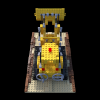

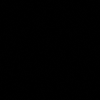

(tensor([[-0.7236, -1.4501,  1.5829, -0.7632,  0.9877, -0.9663, -0.6461, -0.1561,
           0.2576,  0.9863, -0.3083, -0.4977, -0.1651, -0.9513, -0.8673, -0.3256,
           0.5866,  0.8634, -0.9455,  0.8098,  0.5045,  0.6157,  0.9502,  0.8712,
           0.7880,  0.3117, -0.4910,  0.9703,  0.5923, -0.8554,  0.2418, -0.8057,
          -0.5179,  0.4693, -0.9545,  0.8861, -0.8830,  0.2983, -0.4636, -0.8288,
          -0.5694, -0.8215,  0.5596, -0.8220, -0.5702, -0.9275,  0.9362,  0.9369,
          -0.3738,  0.3515, -0.3497,  0.6934,  0.6581, -0.6553, -0.7205, -0.7529,
          -0.7554, -0.9993, -0.9910,  0.9900,  0.0383,  0.1339,  0.1412],
         [-1.0340, -0.5428,  1.4552,  0.1065, -0.9910, -0.9901, -0.9943, -0.1339,
          -0.1401, -0.2119,  0.2655,  0.2775,  0.9773, -0.9641, -0.9607, -0.4141,
          -0.5119, -0.5332,  0.9102,  0.8591,  0.8460, -0.7538, -0.8795, -0.9022,
           0.6571,  0.4760,  0.4314, -0.9906, -0.8372, -0.7783, -0.1365, -0.5469,
          -0.6279,  0.27

(18, 9.270702362060547)

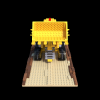

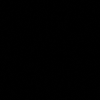

(tensor([[ 0.7770,  1.7616,  1.0036,  0.6446, -0.6808, -0.0114, -0.7646,  0.7325,
          -0.9999, -0.9856, -0.9973,  0.0228,  0.1691,  0.0731,  0.9997, -0.3333,
          -0.1459,  0.0456, -0.9428, -0.9893,  0.9990,  0.6286,  0.2886,  0.0910,
           0.7778,  0.9575,  0.9958,  0.9777,  0.5526,  0.1813,  0.2098,  0.8334,
           0.9834,  0.4103,  0.9211,  0.3566, -0.9119,  0.3892,  0.9343, -0.7483,
           0.7171,  0.6663,  0.6633, -0.6970,  0.7457, -0.9928, -0.9996,  0.9937,
          -0.1200, -0.0284,  0.1120,  0.2383,  0.0567,  0.2226, -0.9712, -0.9984,
          -0.9749, -0.4629, -0.1133, -0.4341,  0.8864,  0.9936,  0.9009],
         [ 0.9711,  1.2026,  1.1292,  0.0906, -0.5945, -0.3949, -0.9959, -0.8041,
          -0.9187, -0.1805,  0.9560,  0.7257,  0.9836,  0.2932,  0.6880, -0.3551,
           0.5607,  0.9986,  0.9348, -0.8280, -0.0532, -0.6638, -0.9285, -0.1063,
           0.7479,  0.3713, -0.9943, -0.9929, -0.6895,  0.2114,  0.1186, -0.7243,
           0.9774, -0.23

(19, 16.75741195678711)

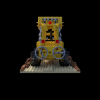

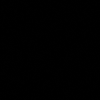

(tensor([[-0.7598, -1.3785,  1.5381, -0.6851,  0.9280, -0.9928, -0.7285, -0.3725,
           0.1194,  0.9981, -0.6913, -0.2371,  0.0614, -0.7225, -0.9715,  0.1226,
           0.9990,  0.4607, -0.9925,  0.0441,  0.8875, -0.2433,  0.0882,  0.8178,
           0.9700, -0.9961,  0.5754, -0.4720, -0.1757,  0.9412,  0.8816,  0.9844,
          -0.3377, -0.8322, -0.3460, -0.6358,  0.5545,  0.9383, -0.7719, -0.9229,
          -0.6492,  0.9815, -0.3851,  0.7606,  0.1916,  0.7108, -0.9876,  0.3760,
          -0.7034,  0.1571, -0.9266, -0.9999, -0.3104, -0.6969, -0.0106, -0.9506,
           0.7172,  0.0212,  0.5901, -0.9996, -0.9998,  0.8073,  0.0287],
         [-1.0295, -0.5876,  1.4445,  0.0927, -0.9623, -0.9848, -0.9957, -0.2718,
          -0.1735, -0.1845,  0.5232,  0.3417,  0.9828, -0.8522, -0.9398, -0.3628,
          -0.8917, -0.6423,  0.9319,  0.4526,  0.7665, -0.6761, -0.8072, -0.9846,
           0.7368, -0.5903,  0.1750, -0.9963,  0.9530, -0.3446,  0.0858, -0.3030,
          -0.9388, -0.17

(20, 9.340271949768066)

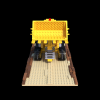

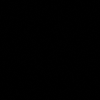

In [ ]:
# PSNR for test dataset

import torch

calculate_loss = MSELossFunction()
model = model.eval()

with torch.no_grad():
    for index in range(test_dataset.count):
        image, posture = test_dataset.get_image_and_posture(index)
        rendered_image = model(posture)
        loss = calculate_loss(rendered_image, image)
        quality = 10 * torch.log10(1 / loss)
        display((index, quality.item()))
        display_image(image)
        display_image(rendered_image)